# Portfolio Analysis Problem Set: Question 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import stats

In [2]:
YEAR = 2012

df = pd.read_csv('{}_data.csv'.format(YEAR), index_col=0)
securities = df.loc[:, 'Agric':'Other']
market = df.loc[:, 'SP500']
interest = df.loc[:, 'LIBOR']

## Part (a)

This part is pretty straightforward.

In [3]:
m = securities.mean()
cov = securities.cov()

## Part (b)

There is fairly good agreement with theory here: all the hyperbola segments appear to lie within the envelope of another, larger hyperbola (the Markowitz bullet). On most years (e.g. 2003, 2004, 2010, 2012), the feasible curves are all segments on the upper arm of a hyperbola: in other words, most underlying securities have positive expected return, and so a convex combination of them (i.e. no short-selling) will also have positive returns. There is stupenous agreement among years with the theory here.

However, in 2008, almost all portfolios correspond to the lower arm of a hyperbola, which means that you couldn't make any money if you held positive quantities of any security: not a surprising result, considering the 2008 financial crisis. The same is true with 2000 and the dot-com crash.

In [4]:
# Naive portfolio
naive = securities.mean(axis=1)
mu_naive = naive.mean()
sigma_naive = naive.std()

In [5]:
# Market portfolio
mu_market = market.mean()
sigma_market = market.std()

In [6]:
# Minimum variance portfolio
sigma_mvp = 1 / np.linalg.inv(cov).sum()
weights_mvp = (sigma_mvp**2 
               * np.linalg.inv(cov) @ np.ones(cov.shape[0]))
mu_mvp = m @ weights_mvp

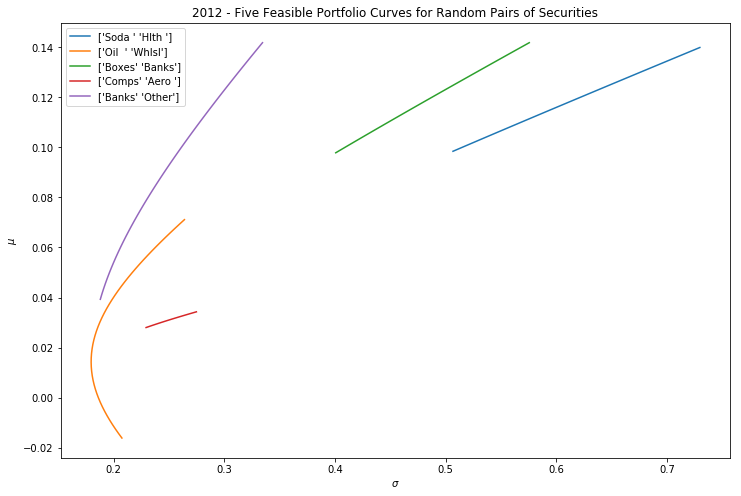

In [7]:
# Plot feasible portfolio curves for 5 random pairs of securities
mu_list = []
sigma_list = []
choices_list = []
for _ in range(5):
    choices = np.random.choice(securities.columns, 2, replace=False)

    mus = securities[choices].mean()
    sigmas = securities[choices].std()
    rho, _ = stats.pearsonr(securities[choices[0]], securities[choices[1]])
    A_sq = np.sqrt((sigmas[0]**2 + sigmas[1]**2 - 2*rho*sigmas[0]*sigmas[1])
                   / (mus[0] - mus[1]) ** 2)
    
    mu_v = np.linspace(mus.min(), mus.max())
    sigma_v = np.sqrt(sigma_mvp**2 + A_sq * (mu_v - mu_mvp)**2)

    mu_list.append(mu_v)
    sigma_list.append(sigma_v)
    choices_list.append(str(choices))

plt.figure(figsize=[12, 8])
for mu_v, sigma_v in zip(mu_list, sigma_list):
    plt.plot(sigma_v, mu_v)

plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.title('{} - Five Feasible Portfolio Curves for Random Pairs of Securities'.format(YEAR))
plt.legend(choices_list);

## Part (c)

Depending on the year, the upper half of the hyperbola (i.e. the efficient frontier) may appear very straight. 2003, 2004 and 2010 have curves so straight they look linear, whereas 2000 and 2008 has negative sloping efficient frontier (2014 has a "regular-looking" arm of a hyperbola). This means, somewhat nonsensically, that there is a negative risk premium: again, this is not surprising considering the financial crises of 2000 and 2008 and the violations of the assumptions of Markowitz portfolio theory.

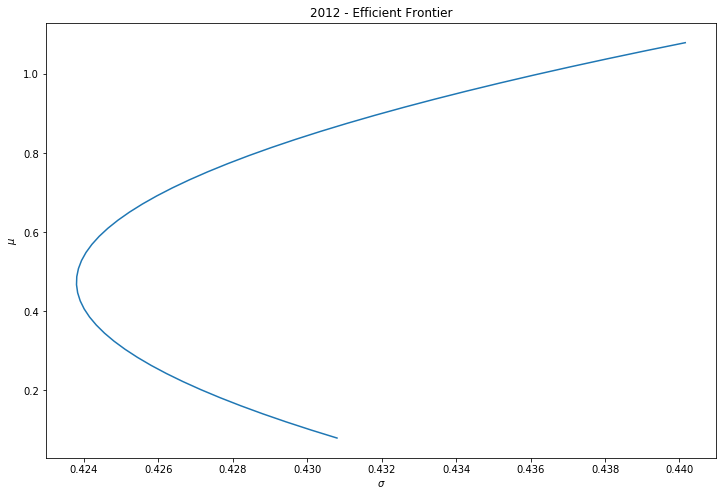

In [8]:
# Compute and graph efficient frontier
m_tilde = np.vstack([m, np.ones(m.shape)]).T
B = m_tilde.T @ np.linalg.inv(cov) @ m_tilde
G = (np.linalg.inv(B) @ m_tilde.T
     @ np.linalg.inv(cov) @ m_tilde @ np.linalg.inv(B))
a, d, _, b = G.flatten()

mu_mvp = - d / a
sigma_mvp = np.sqrt(np.linalg.det(G) / a)

mus = np.linspace(mu_mvp, mu_mvp + 1)  # A bit of kludge here...
sigmas = np.sqrt(a*(mu_v + d/a)**2 + (1/a)*np.linalg.det(G))

plt.figure(figsize=[12, 8])
plt.plot(sigmas, mus)
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.title('{} - Efficient Frontier'.format(YEAR));

## Part (d)

In almost all cases (e.g. 2003, 2004, 2010, 2012), increasing mus imply increasing sigmas, thanks to the agreement with theory in part (b). Furthermore, in almost all cases (the same years as above), $w_2$ is found to be a convex combination of $w_1$ and $w_3$. This means that efficient portfolios all lie in a line segment in $w$-space, in accordance with the theory. There is amazing agreement with theory here, across many years.

2000 and 2008 are outliers, in which increasing mus do not imply increasing sigmas, but it is still the case that $w_2$ is a convex combination of $w_1$ and $w_3$. One can only assume that the financial crash ruined many of the assumptions of Markowitz theory (e.g. no arbitrage, for instance), which ruins any theoretical guarantees.

In [9]:
choices = np.random.choice(mu_v.shape[0], 3, replace=False)

# Find indices that sort the chosen mu_v's
indices = np.argsort(mu_v[choices])

# Check if the sorted sigma_v's are increasing (i.e. positive differences)
increasing = (np.diff(sigma_v[choices][indices]) > 0).all()

msg = ('Increasing mus imply increasing sigmas.' if increasing
       else 'Increasing mus do NOT imply increasing sigmas!')
print(msg)

Increasing mus imply increasing sigmas.


In [10]:
def mu_to_weights(mu):
    mu_tilde = np.vstack([mu, 1])
    return (np.linalg.inv(cov) @ m_tilde
            @ np.linalg.inv(B) @ mu_tilde).flatten()


mu1, mu2, mu3 = mu_v[choices]
sigma1, sigma2, sigma3 = sigma_v[choices][indices]  # For part (g)

w1 = mu_to_weights(mu1)
w2 = mu_to_weights(mu2)
w3 = mu_to_weights(mu3)

In [15]:
# For the first security, solve the equation alpha*w1 + (1-alpha)*w3 = w2
# This alpha should work for all securities.
alpha = (w2[0] - w3[0]) / (w1[0] - w3[0])

is_combo = np.allclose(alpha*w1 + (1-alpha)*w3, w2)
msg = ('w2 is a convex combination of w1 and w3.' if is_combo
       else 'w2 is NOT a convex combination of w1 and w3!')
print(msg)

w2 is a convex combination of w1 and w3.


## Part (e)

After the correction in the portfolio notes...

In many cases (e.g. 2003, 2004, 2010, 2012), the risk-free rate is higher than the mean minimum variance portfolio returns, in agreement with theory. Again, 2008 is the exception: you would've done well to just put all your money in the money market, because even the minimum-variance portfolio failed to outperform the money market!

Aside: I originally forgot to convert the LIBOR from three-month returns to daily returns: the first time I actually looked at the data was when I got interest rates consistently higher than mean minimum-variance returns, and was shocked at "daily interest rates" of 6%. And yet this didn't change any of my results. Lol.

In [16]:
R = interest.mean()

msg = 'R < mu_mvp.' if R < mu_mvp else 'R is NOT < mu_mvp!'
print(msg)

R < mu_mvp.


## Part (f)

In most cases, the capital market line exists and has a positive slope (i.e. it passes the common-sense test). This holds true for most years (e.g. 2000, 2003, 2004, 2010, 2012), so this result is extremely consistent.

However, if $ \mu_{M} < R $, (which is sometimes the case), then the capital market line does not have a positive slope (which is nonsensical, since you would never take on more risk to _lower_ your expected return), and it also does not lie tangent to the Markowitz bullet (instead, it intersects it, cutting through the interior of the bullet). This is true for the "crisis" year of 2008, for instance. However, 2000 (with its dot-com crash) still has a positively sloping capital market line: perhaps the dot-com crash did not violate the core assumptions of Markowitz theory, but the 2008 crash did?

In [17]:
R = interest.mean()
m_ex = m - R
w_M = (1 / (np.linalg.inv(cov) @ m_ex).sum()) * np.linalg.inv(cov) @ m_ex
mu_M = m.T @ w_M
sigma_M = np.sqrt(w_M.T @ cov @ w_M)

sigmas = np.linspace(0, 1)
mus = R + ((mu_M - R) / sigma_M) * sigmas  # Capital Market Line

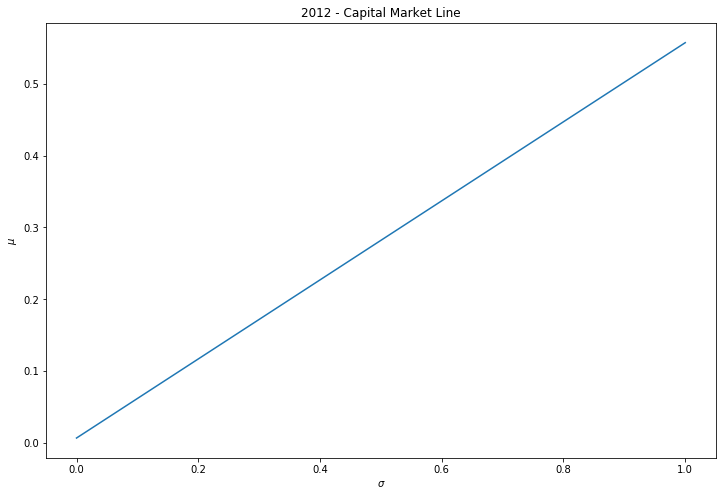

In [19]:
plt.figure(figsize=[12, 8])
plt.plot(sigmas, mus)
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.title('{} - Capital Market Line'.format(YEAR));

## Part (g)

This is a toss in all ways: most years lie in a line of zero slope, whereas some look more scattered. In no case do they ever actually align into a positively or negatively sloping line. I have no idea why this is: a horizontal line would imply that each portfolio is fairly uncorrelated with the market, irrespective of the expected returns.

In [20]:
def weights_to_beta(weights):
    returns_portfolio = (weights * securities).sum(axis=1)
    # np.cov returns cov matrix; get the diagonal element
    cov = np.cov(returns_portfolio, market)[0, 1]
    beta = cov / sigma_M**2
    return beta, returns_portfolio  # Return portfolio returns for part (h)

In [25]:
weights_mvp

array([-1.26500894e-02,  2.66598219e-02,  9.72380217e-03,  9.25872757e-03,
       -1.16132957e-05,  1.17528890e-02,  1.23888775e-04, -1.58945936e-03,
        3.79431494e-03, -8.75696254e-03,  1.93916802e-02,  6.46003010e-03,
       -1.13900675e-02, -3.94627209e-03, -8.36081630e-04, -4.48859411e-03,
       -1.31083037e-02, -2.28775162e-02, -1.36526122e-02,  5.02399100e-03,
       -2.27336395e-04,  9.75862117e-03, -2.98025597e-02, -1.55044204e-03,
       -1.24048289e-03, -4.67066985e-03, -2.00576799e-03,  5.25013683e-03,
        8.56624264e-04, -2.30821528e-02,  7.31796858e-02, -1.84558558e-02,
       -5.89778602e-03,  5.01786915e-02,  7.08526122e-03, -8.15915810e-03,
        1.02069695e-02, -9.48671859e-04,  1.21109775e-02, -1.37681938e-02,
        4.86124744e-02,  6.49158687e-03,  1.90574412e-02,  6.41443731e-02,
        5.45231189e-03, -1.72860192e-03, -3.41561812e-02,  1.40347509e-02])

In [21]:
beta_mvp, returns_mvp = weights_to_beta(weights_mvp)
beta1, returns1 = weights_to_beta(w1)
beta2, returns2 = weights_to_beta(w2)
beta3, returns3 = weights_to_beta(w3)
beta_naive, returns_naive = weights_to_beta(np.ones(48) / 48)

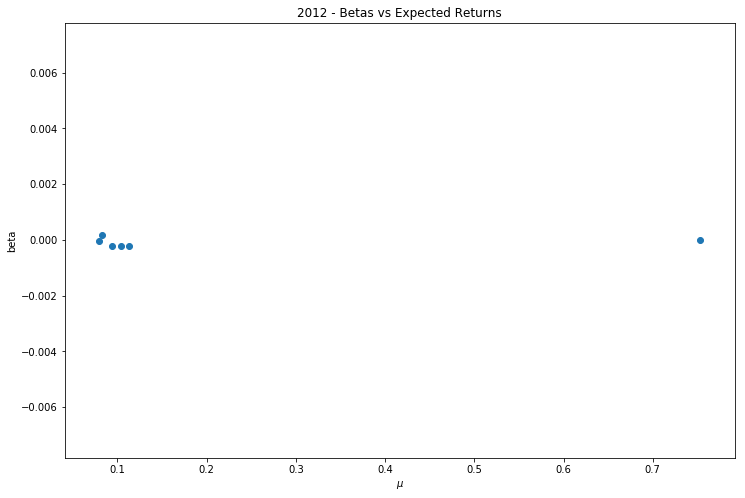

In [22]:
fig = plt.figure(figsize=[12, 8])
mus = [mu_M, mu_mvp, mu1, mu2, mu3, mu_naive]
betas = [0, beta_mvp, beta1, beta2, beta3, beta_naive]
plt.scatter(mus, betas)
plt.title('{} - Betas vs Expected Returns'.format(YEAR))
plt.xlabel('$\mu$')
plt.ylabel('beta');

## Part (h)

Depending on the year, and your luck with the randomly chosen portfolios, these equity curves may seem very unreasonable. Oddly enough, for a few years (e.g. 2004), the naive portfolio fluctuates wildly, achieving returns as much as 250% and as low as -100%. This may be due to a data error, or could be attributable to naivety of the portfolio itself (since it usually achieves a mean return very close to 0).

In [23]:
equity_market = (1+market).cumprod()
equity_naive = (1+returns_naive).cumprod()
equity_mvp = (1+returns_mvp).cumprod()

equity1 = (1+returns1).cumprod()
equity2 = (1+returns2).cumprod()
equity3 = (1+returns3).cumprod()

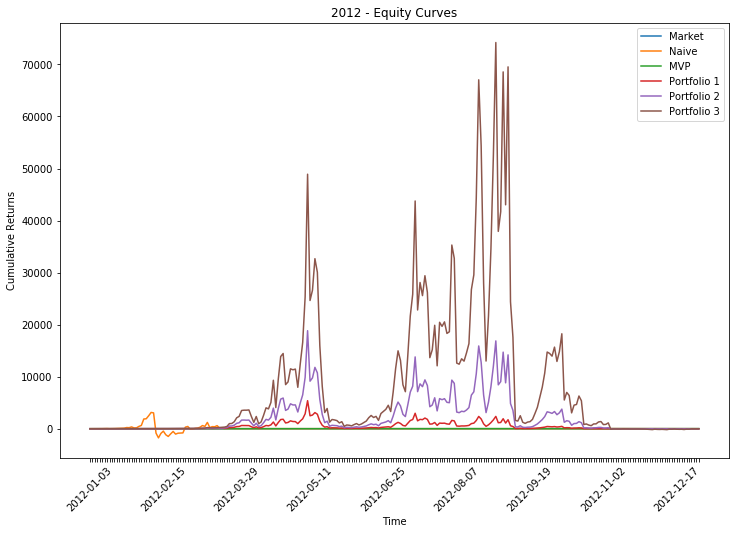

In [24]:
fig = plt.figure(figsize=[12, 8])

plt.plot(equity_market, label='Market')
plt.plot(equity_naive, label='Naive')
plt.plot(equity_mvp, label='MVP')
plt.plot(equity1, label='Portfolio 1')
plt.plot(equity2, label='Portfolio 2')
plt.plot(equity3, label='Portfolio 3')

# Ugly hack to only show one x tick for every 30 days
for index, label in enumerate(fig.axes[0].xaxis.get_ticklabels()):
    if index % 30 != 0:
        label.set_visible(False)
    
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('{} - Equity Curves'.format(YEAR))
plt.xticks(rotation=45)
plt.legend();